In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('Symptom2Disease.csv')

data['text'] = data['text'].str.lower()

data.drop(columns=[data.columns[0]], inplace=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_data = tokenizer(data['text'].tolist(), padding=True, truncation=True, max_length=512, return_tensors='tf')

bert = TFBertModel.from_pretrained('bert-base-uncased')

input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')

embeddings = bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

dropout_layer = Dropout(0.1)
x2 = dropout_layer(embeddings[:, 0, :], training=True)

output = Dense(len(data['label'].unique()), activation='softmax')(x2)

print(f"OUTPUT:    {output}")

model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer=legacy_optimizers.Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

labels = pd.get_dummies(data['label']).values

train_features, test_features, train_labels, test_labels, train_masks, test_masks = train_test_split(
    tokenized_data['input_ids'].numpy(), 
    labels, 
    tokenized_data['attention_mask'].numpy(),
    test_size=0.2, 
    random_state=42, 
    stratify=labels
)

train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_features, 'attention_mask': train_masks}, train_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': test_features, 'attention_mask': test_masks}, test_labels)).batch(32)

history = model.fit(train_dataset, validation_data=test_dataset, epochs=3)

results = model.evaluate(test_dataset)
print(f'Test Loss: {results[0]}, Test Accuracy: {results[1]}')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
30/30 [==============================] - 104s 3s/step - loss: 2.2263 - accuracy: 0.4208 - val_loss: 0.5980 - val_accuracy: 0.8708
Epoch 2/3
30/30 [==============================] - 95s 3s/step - loss: 0.3076 - accuracy: 0.9271 - val_loss: 0.1132 - val_accuracy: 0.9833
Epoch 3/3
8/8 [==============================] - 8s 931ms/step - loss: 0.0514 - accuracy: 0.9958
Test Loss: 0.05143994092941284, Test Accuracy: 0.9958333373069763


8/8 [==============================] - 7s 920ms/step


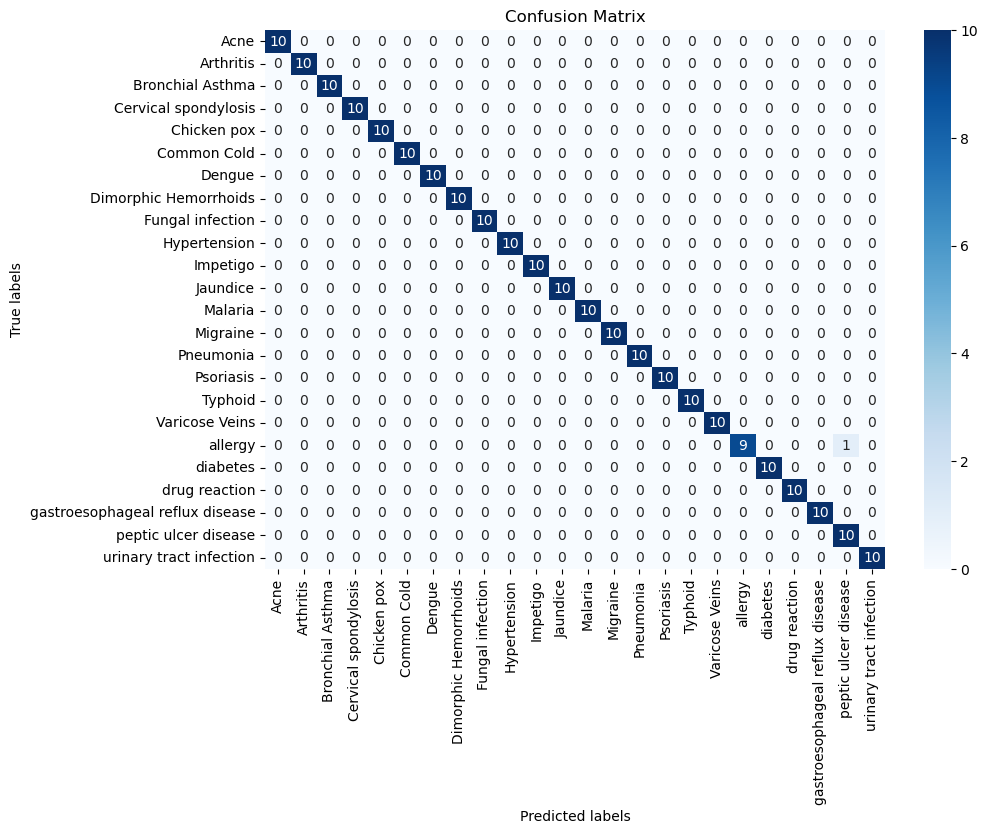

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
labels = to_categorical(data['label'])

test_pred = model.predict(test_dataset)
test_pred_labels = np.argmax(test_pred, axis=1)
true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, test_pred_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [1]:
def extract_symptoms_with_filter(data_path, symptom_terms):
    data = pd.read_csv(data_path)
    
    data['label'] = data['label'].str.strip()
    data['text'] = data['text'].str.lower()
    
    symptoms_by_disease = defaultdict(list)
    
    negation_patterns = r"(no|not|never|don't|doesn't|without)\s+"
    
    for _, row in data.iterrows():
        negated_symptoms = []
        for term in symptom_terms:
            if re.search(negation_patterns + term, row['text']):
                negated_symptoms.append("no " + term)

        words = row['text'].split()
        filtered_symptoms = [word for word in words if word in symptom_terms and "no " + word not in negated_symptoms]
        symptoms_by_disease[row['label']].extend(filtered_symptoms)
    
    common_symptoms_by_disease = {}
    for disease, symptoms in symptoms_by_disease.items():
        symptom_count = Counter(symptoms)
        common_symptoms_by_disease[disease] = [symptom for symptom, count in symptom_count.most_common(3)]
    
    return common_symptoms_by_disease

symptom_terms = set([
    'fever', 'cough', 'fatigue', 'headache', 'nausea', 'dizziness', 'rash', 'peeling', 'swelling',
    'inflamed', 'bumps', 'blackheads', 'weak', 'vomiting', 'dry', 'pain', 'itching', 'swollen', 'cramps',
    'ache', 'bleeding', 'blurred vision', 'burning', 'constipation', 'diarrhea', 'itch', 'numbness', 'palpitations',
    'tenderness', 'tingling', 'weakness', 'wheezing', 'discharge', 'sore', 'redness', 'inflammation'
])

common_symptoms = extract_symptoms_with_filter('Symptom2Disease.csv', symptom_terms)

NameError: name 'pd' is not defined

In [ ]:
def softmax_with_temperature(logits, temperature=1):
    if logits.ndim == 1:
        logits = logits.reshape(1, -1)  
    e_x = np.exp(logits / temperature)
    return e_x / e_x.sum(axis=1, keepdims=True)

def predict_with_uncertainty(model, tokenized_input, n_iter=10):
    predictions = [model.predict({'input_ids': tokenized_input['input_ids'], 'attention_mask': tokenized_input['attention_mask']}, verbose=0) for _ in range(n_iter)]
    predictions = np.array(predictions)
    mean_predictions = np.mean(predictions, axis=0)
    std_devs = np.std(predictions, axis=0)
    mean_probabilities = softmax_with_temperature(mean_predictions, temperature=0.5)
    covs = np.divide(std_devs, mean_probabilities, out=np.zeros_like(std_devs), where=mean_probabilities!=0)
    return mean_probabilities.flatten(), covs.flatten() 

In [7]:
def interact_with_user(symptom_description, n_iter=10):
    tokenized_input = tokenizer(symptom_description, padding=True, truncation=True, max_length=512, return_tensors='tf')
    predicted_probabilities, prediction_uncertainties = predict_with_uncertainty(model, tokenized_input, n_iter)

    sorted_indices = np.argsort(predicted_probabilities)[::-1]
    labels_list = pd.get_dummies(data['label']).columns.tolist()
    
    top_diseases = [(labels_list[idx], predicted_probabilities[idx], prediction_uncertainties[idx]) for idx in sorted_indices[:3]]
    for disease, probability, uncertainty in top_diseases:
        print(f"Disease: {disease}, Confidence: {probability*100:.2f}%, Uncertainty: {uncertainty:.5f}")

    disease_prediction, max_probability, uncertainty = top_diseases[0]
    confidence_percentage = max_probability * 100

    if confidence_percentage < 75:
        response = input(f"I believe your diagnosis is {disease_prediction}. Is this right? Some common symptoms include: {', '.join(common_symptoms[disease_prediction])}. (yes/no): ")
        if response.lower() == 'yes':
            print(f"Diagnosis confirmed: {disease_prediction} with confidence {confidence_percentage:.2f}%")
        else:
            print("Please consult a medical professional for further evaluation.")
    else:
        print(f"Diagnosis: {disease_prediction} with high confidence {confidence_percentage:.2f}% and low uncertainty {uncertainty:.5f}")

# Example usage of the interaction function
symptom = "I have a nasty rash on my skin. It's covered in blackheads and pimples that are filed with pus."
interact_with_user(symptom)

Disease: Acne, Confidence: 23.15%, Uncertainty: 0.03901
Disease: Fungal infection, Confidence: 3.41%, Uncertainty: 0.10280
Disease: Impetigo, Confidence: 3.40%, Uncertainty: 0.12614


I believe your diagnosis is Acne. Is this right? Some common symptoms include: rash, blackheads, itching. (yes/no):  yes


Diagnosis confirmed: Acne with confidence 23.15%
